# Meta Learning Forecasting

In [1]:
"""

@ author: Taehyeong Kim, Fusion Data Analytics and Artificial Intelligence Lab

"""

import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sklearn as sk
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input, layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K

import os
import random

seed=1011

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

set_seeds()

import warnings
warnings.filterwarnings('ignore')

print("scikit-learn : ", sk.__version__)
print("tensorflow : ", tf.__version__)

scikit-learn :  0.24.2
tensorflow :  2.3.0


## Data Preprocessing

In [2]:
# Read data file
data = pd.read_excel("./sampling_data.xlsx", header=0, engine='openpyxl')
data.drop("item", axis=1, inplace=True)

data['2010sprt'] = data['2010ea'] * data['2010rate']
data['2011sprt'] = data['2011ea'] * data['2011rate']
data['2012sprt'] = data['2012ea'] * data['2012rate']
data['2013sprt'] = data['2013ea'] * data['2013rate']
data['2014sprt'] = data['2014ea'] * data['2014rate']
data['2015sprt'] = data['2015ea'] * data['2015rate']
data['2016sprt'] = data['2016ea'] * data['2016rate']

data.head()

,2010ea,2010rate,2010OP,2010SORT,2011ea,2011rate,2011OP,2011SORT,2012ea,2012rate,...,2016OP,2016SORT,Forecasting,2010sprt,2011sprt,2012sprt,2013sprt,2014sprt,2015sprt,2016sprt
0,0.0,0.000000,123488,2007,2.0,2.00,145911,2285,4.0,2.50,...,129946,2064,1,0.000000,4.00,10.0,6.0,28.0,0.0,4.0
1,3.0,1.000000,123488,2007,5.0,1.75,145911,2285,12.0,1.75,...,129946,2064,1,3.000000,8.75,21.0,38.0,42.0,15.0,8.0
2,0.0,0.000000,1080820,14283,0.0,0.00,1123702,12972,0.0,0.00,...,1038927,12553,1,0.000000,0.00,0.0,0.0,0.0,0.0,0.0
3,4.0,2.000000,123488,2007,5.0,2.50,145911,2285,1.0,1.00,...,129946,2064,1,8.000000,12.50,1.0,2.0,1.0,0.0,0.0
4,16.0,2.628571,255942,3168,1.0,1.00,261298,3404,4.0,2.50,...,231134,3135,1,42.057143,1.00,10.0,12.0,25.0,8.0,6.0


In [3]:
X_train = data.drop(columns=['2016ea', '2016rate', '2016OP', '2016SORT', '2016sprt', 'Forecasting'])
X_test = data.drop(columns=['2016ea', '2016rate', '2016OP', '2016SORT', '2016sprt', 'Forecasting'])
y_train = data["2016ea"].apply(lambda x : 0 if x<0.5 else 1).values
y_test = data.Forecasting.values

scaler=StandardScaler().fit(X_train)
X_train=scaler.transform(X_train)
X_test=scaler.transform(X_test)

X_train.shape, X_test.shape

((2000, 30), (2000, 30))

In [4]:
X1 = data.loc[:, ['2010ea', '2011ea', '2012ea', '2013ea', '2014ea', '2015ea']].values
X2 = data.loc[:, ['2010rate', '2011rate', '2012rate', '2013rate', '2014rate', '2015rate']].values
X3 = data.loc[:, ['2010OP', '2011OP', '2012OP', '2013OP', '2014OP', '2015OP']].values
X4 = data.loc[:, ['2010SORT', '2011SORT', '2012SORT', '2013SORT', '2014SORT', '2015SORT']].values
X5 = data.loc[:, ['2010sprt', '2011sprt', '2012sprt', '2013sprt', '2014sprt', '2015sprt']].values
X_2d_train=np.concatenate([X1, X2, X3, X4, X5], axis=1)

X1 = data.loc[:, ['2011ea', '2012ea', '2013ea', '2014ea', '2015ea', '2016ea']].values
X2 = data.loc[:, ['2011rate', '2012rate', '2013rate', '2014rate', '2015rate', '2016rate']].values
X3 = data.loc[:, ['2011OP', '2012OP', '2013OP', '2014OP', '2015OP', '2016OP']].values
X4 = data.loc[:, ['2011SORT', '2012SORT', '2013SORT', '2014SORT', '2015SORT', '2016SORT']].values
X5 = data.loc[:, ['2011sprt', '2012sprt', '2013sprt', '2014sprt', '2015sprt', '2016sprt']].values
X_2d_test=np.concatenate([X1, X2, X3, X4, X5], axis=1)

y_train = data["2016ea"].apply(lambda x : 0 if x<0.5 else 1).values
y_test = data.Forecasting.values

scaler_2d=MinMaxScaler().fit(X_2d_train)
X_2d_train=scaler_2d.transform(X_2d_train)
X_2d_test=scaler_2d.transform(X_2d_test)

X_3d_train=X_2d_train.reshape((len(X_2d_train), 5, 6)).transpose(0,2,1)
X_3d_test=X_2d_test.reshape((len(X_2d_test), 5, 6)).transpose(0,2,1)

X_3d_train.shape, X_3d_test.shape

((2000, 6, 5), (2000, 6, 5))

## 1. Level 0

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import xgboost
import lightgbm
import catboost
print("xgboost : ", xgboost.__version__)
print("lightgbm : ", lightgbm.__version__)
print("catboost : ", catboost.__version__)

xgboost :  1.2.0
lightgbm :  3.1.1
catboost :  0.25.1


* models

In [6]:
estimator1 = LogisticRegression(n_jobs=-1, random_state=seed)
estimator2 = GaussianNB()
estimator3 = KNeighborsClassifier(n_jobs=-1)
estimator4 = SVC(random_state=seed, probability=True)
estimator5 = DecisionTreeClassifier(random_state=seed)
estimator6 = RandomForestClassifier(n_jobs=-1, random_state=seed)
estimator7 = AdaBoostClassifier(random_state=seed)
estimator8 = XGBClassifier(n_jobs=-1, random_state=seed)
estimator9 = LGBMClassifier(n_jobs=-1, random_state=seed)
estimator10 = CatBoostClassifier(verbose=False, random_state=seed)
estimator11 = MLPClassifier(random_state = seed)


def rnn(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.SimpleRNN(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def lstm(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.LSTM(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def gru(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.GRU(32, input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def cnn1d(trainX, trainy):
    set_seeds()
    model = Sequential() # Sequeatial Model
    model.add(layers.Conv1D(32, 3, kernel_initializer='he_normal',
                            input_shape=(trainX.shape[1], trainX.shape[2]))) # (timestep, feature)
    model.add(layers.Flatten())
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid')) # output = 1
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model

def attrnn(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.SimpleRNN(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def attlstm(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.LSTM(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model


def attgru(trainX, trainy):
    set_seeds()
    inputs = Input(shape=(trainX.shape[1], trainX.shape[2]))
    x = layers.GRU(32, return_sequences=True)(inputs)
    input_dim = int(x.shape[2])
    att = layers.Dense(1, activation='tanh')(x)
    att = layers.Flatten()(att)
    att = layers.Activation('softmax')(att)
    att = layers.RepeatVector(input_dim)(att)
    att = layers.Permute([2, 1])(att)
    att = layers.Multiply()([x, att])
    att = layers.Lambda(lambda x: K.sum(x, axis=-2), output_shape=(input_dim,))(att)
    x = layers.Dense(16, activation="relu")(att)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    callback = EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True)
    model.fit(trainX, trainy,
              validation_split=0.2,
              epochs=EPOCHS, batch_size=BATCH_SIZE,
              callbacks=callback)
    return model

* Machine Learning

In [7]:
def get_stacking_ml_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    
    skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seed)
    
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    
    for folder_counter, (train_index, valid_index) in enumerate(skf.split(X_train_n, y_train_n)):
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict_proba(X_te)[:,1].reshape(-1,1)
        test_pred[:, folder_counter] = model.predict_proba(X_test_n)[:,1]
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    return train_fold_pred, test_pred_mean

In [8]:
%%time

base_ml = [estimator1, estimator2, estimator3, estimator4, estimator5,
           estimator6, estimator7, estimator8, estimator9, estimator10,
           estimator11]

meta_ml_X_train=[]
meta_ml_X_test=[]
for estimator in base_ml:
    temp_X_train, temp_X_test = get_stacking_ml_datasets(estimator, X_train, y_train, X_test, 5)
    meta_ml_X_train.append(temp_X_train)
    meta_ml_X_test.append(temp_X_test)
    
meta_ml_X_train=np.hstack(meta_ml_X_train)
meta_ml_X_test=np.hstack(meta_ml_X_test)

meta_ml_X_train.shape, meta_ml_X_test.shape

Wall time: 29.3 s


((2000, 11), (2000, 11))

* Deep Learning

In [9]:
EPOCHS=100
BATCH_SIZE=len(data)

In [10]:
model1=rnn(X_3d_train, y_train)
model2=lstm(X_3d_train, y_train)
model3=gru(X_3d_train, y_train)
model4=cnn1d(X_3d_train, y_train)
model5=attrnn(X_3d_train, y_train)
model6=attlstm(X_3d_train, y_train)
model7=attgru(X_3d_train, y_train)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                1216      
_________________________________________________________________
dense (Dense)                (None, 16)                528       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 1,761
Trainable params: 1,761
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
1/1 [==============================] - 0s 164ms/step - loss: 0.7112 - accuracy: 0.4250 - val_loss: 0.7320 - val_accuracy: 0.2225
Epoch 2/100
1/1 [==============================] - 0s 11ms/step - loss: 0.7039 - accuracy: 0.4881 - val_loss: 0.7151 - val_accuracy: 0.1925
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 0.6975 - accuracy: 0.5088 - val

1/1 [==============================] - 0s 13ms/step - loss: 0.6577 - accuracy: 0.6575 - val_loss: 0.6471 - val_accuracy: 0.5525
Epoch 27/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6564 - accuracy: 0.6575 - val_loss: 0.6462 - val_accuracy: 0.5525
Epoch 28/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6552 - accuracy: 0.6575 - val_loss: 0.6456 - val_accuracy: 0.5525
Epoch 29/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6539 - accuracy: 0.6575 - val_loss: 0.6450 - val_accuracy: 0.5525
Epoch 30/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6527 - accuracy: 0.6575 - val_loss: 0.6445 - val_accuracy: 0.5525
Epoch 31/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6515 - accuracy: 0.6575 - val_loss: 0.6440 - val_accuracy: 0.5525
Epoch 32/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6503 - accuracy: 0.6575 - val_loss: 0.6439 - val_accuracy: 0.5525
Epoch 33/100
1/1 [========

Epoch 13/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6548 - accuracy: 0.6575 - val_loss: 0.6008 - val_accuracy: 0.5525
Epoch 14/100
1/1 [==============================] - 0s 10ms/step - loss: 0.6526 - accuracy: 0.6575 - val_loss: 0.6053 - val_accuracy: 0.5525
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 6, 5)]       0                                            
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 6, 32)        1216        input_1[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 6, 1)         33          simple_rnn_1[0][0]               
___

Epoch 5/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6796 - accuracy: 0.6231 - val_loss: 0.6508 - val_accuracy: 0.5850
Epoch 6/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6784 - accuracy: 0.6263 - val_loss: 0.6489 - val_accuracy: 0.5850
Epoch 7/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6773 - accuracy: 0.6281 - val_loss: 0.6471 - val_accuracy: 0.5850
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6762 - accuracy: 0.6313 - val_loss: 0.6454 - val_accuracy: 0.5850
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6752 - accuracy: 0.6388 - val_loss: 0.6438 - val_accuracy: 0.5525
Epoch 10/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6741 - accuracy: 0.6562 - val_loss: 0.6421 - val_accuracy: 0.5525
Epoch 11/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6731 - accuracy: 0.6575 - val_loss: 0.6405 - val_accuracy: 0.5525
Epoch 12/100
1/1 [

1/1 [==============================] - 0s 13ms/step - loss: 0.6750 - accuracy: 0.6575 - val_loss: 0.6519 - val_accuracy: 0.5525
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6734 - accuracy: 0.6575 - val_loss: 0.6500 - val_accuracy: 0.5525
Epoch 9/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6719 - accuracy: 0.6575 - val_loss: 0.6483 - val_accuracy: 0.5525
Epoch 10/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6705 - accuracy: 0.6575 - val_loss: 0.6466 - val_accuracy: 0.5525
Epoch 11/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6690 - accuracy: 0.6575 - val_loss: 0.6451 - val_accuracy: 0.5525
Epoch 12/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6676 - accuracy: 0.6575 - val_loss: 0.6438 - val_accuracy: 0.5525
Epoch 13/100
1/1 [==============================] - 0s 13ms/step - loss: 0.6662 - accuracy: 0.6575 - val_loss: 0.6428 - val_accuracy: 0.5525
Epoch 14/100
1/1 [==========

In [11]:
# DL_1

base_dl = [model1, model2, model3, model4, model5, model6, model7]
base_dl2 = []

for model in base_dl:
    output=model.layers[-2].output
    model=Model(inputs=model.input, outputs=output)
    base_dl2.append(model)

meta_dl_X_train=[]
meta_dl_X_test=[]
for model in base_dl2:
    temp_X_train=model.predict(X_3d_train)
    temp_X_test=model.predict(X_3d_test)
    meta_dl_X_train.append(temp_X_train)
    meta_dl_X_test.append(temp_X_test)
    
meta_dl_X_train=np.hstack(meta_dl_X_train)
meta_dl_X_test=np.hstack(meta_dl_X_test)

meta_dl_X_train.shape, meta_dl_X_test.shape

((2000, 112), (2000, 112))

* Meta Data

In [12]:
model_name = ["LR", "NB", "KNN", "SVM", "DT", 
              "RF", "AB", "XGB", "LGBM", "CB",
              "MLP",
              "RNN", "LSTM", "GRU", "1DCNN", "AttRNN", "AttLSTM", "AttGRU"]

len(model_name)

18

In [13]:
meta_X_train=np.concatenate((meta_ml_X_train, meta_dl_X_train), axis=1)
meta_X_test=np.concatenate((meta_ml_X_test, meta_dl_X_test), axis=1)

# CSV save
# mdc=model_name.copy()
# mdc.append("Target")
mdtrain=pd.DataFrame(np.concatenate((meta_X_train, y_train.reshape(len(y_train), 1)), axis=1))#, columns=mdc)
mdtrain.to_csv("Meta_train_6Y_210812.csv", index=False)
mdtest=pd.DataFrame(np.concatenate((meta_X_test, y_test.reshape(len(y_test), 1)), axis=1))#, columns=mdc)
mdtest.to_csv("Meta_test_6Y_210812.csv", index=False)

meta_X_train.shape, meta_X_test.shape

((2000, 123), (2000, 123))

## 2. Level 1

model: LR (ML)
accuracy: 0.802
precision: 0.865
recall: 0.714
f1: 0.782

model: LR (DL)
accuracy: 0.661
precision: 0.63
recall: 0.778
f1: 0.697

model: LR (ML+DL)
accuracy: 0.804
precision: 0.868
recall: 0.718
f1: 0.786

model: SVM (ML)
accuracy: 0.801
precision: 0.901
recall: 0.676
f1: 0.773

model: SVM (DL)
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691

model: SVM (ML+DL)
accuracy: 0.798
precision: 0.895
recall: 0.676
f1: 0.77



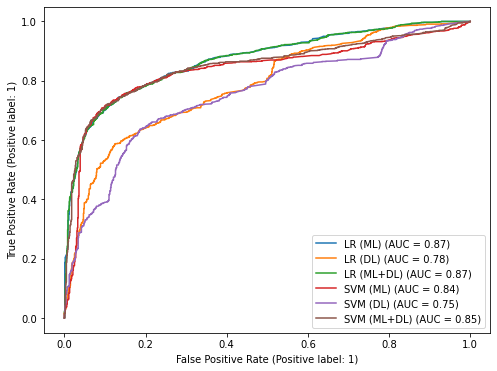

In [14]:
meta1=LogisticRegression(n_jobs=-1, random_state=seed)
meta2=SVC(random_state=seed, probability=True)

meta_models = [meta1, meta2]
meta_ml_model_name = ["LR (ML)", "SVM (ML)"]
meta_dl_model_name = ["LR (DL)", "SVM (DL)"]
meta_model_name = ["LR (ML+DL)", "SVM (ML+DL)"]


# ROC_Curve
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for index, clf in enumerate(meta_models):
    
    clf.fit(meta_ml_X_train, y_train)
    y_pred=clf.predict(meta_ml_X_test)
    
    print("model:", meta_ml_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_roc_curve(clf, meta_ml_X_test, y_test,
                   name=meta_ml_model_name[index], ax=ax)
    
    clf.fit(meta_dl_X_train, y_train)
    y_pred=clf.predict(meta_dl_X_test)
    
    print("model:", meta_dl_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_roc_curve(clf, meta_dl_X_test, y_test,
                   name=meta_dl_model_name[index], ax=ax)
    
    clf.fit(meta_X_train, y_train)
    y_pred=clf.predict(meta_X_test)
    
    print("model:", meta_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_roc_curve(clf, meta_X_test, y_test,
                   name=meta_model_name[index], ax=ax)
    
plt.savefig("./figure/ML+DL_AUROC.png")

model: LR (ML)
accuracy: 0.802
precision: 0.865
recall: 0.714
f1: 0.782

model: LR (DL)
accuracy: 0.661
precision: 0.63
recall: 0.778
f1: 0.697

model: LR (ML+DL)
accuracy: 0.804
precision: 0.868
recall: 0.718
f1: 0.786

model: SVM (ML)
accuracy: 0.801
precision: 0.901
recall: 0.676
f1: 0.773

model: SVM (DL)
accuracy: 0.647
precision: 0.614
recall: 0.79
f1: 0.691

model: SVM (ML+DL)
accuracy: 0.798
precision: 0.895
recall: 0.676
f1: 0.77



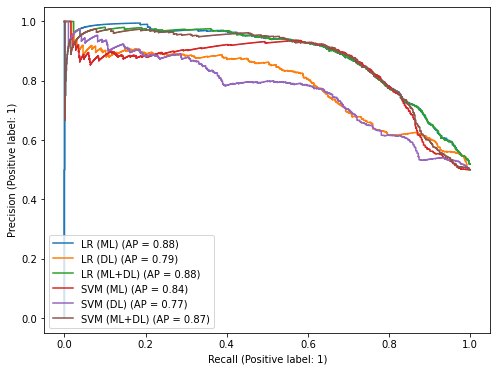

In [15]:
meta1=LogisticRegression(n_jobs=-1, random_state=seed)
meta2=SVC(random_state=seed, probability=True)

meta_models = [meta1, meta2]
meta_ml_model_name = ["LR (ML)", "SVM (ML)"]
meta_dl_model_name = ["LR (DL)", "SVM (DL)"]
meta_model_name = ["LR (ML+DL)", "SVM (ML+DL)"]


# Precision_Recall_Curve
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for index, clf in enumerate(meta_models):
    
    clf.fit(meta_ml_X_train, y_train)
    y_pred=clf.predict(meta_ml_X_test)
    
    print("model:", meta_ml_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_precision_recall_curve(clf, meta_ml_X_test, y_test,
                                name=meta_ml_model_name[index], ax=ax)
    
    clf.fit(meta_dl_X_train, y_train)
    y_pred=clf.predict(meta_dl_X_test)
    
    print("model:", meta_dl_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_precision_recall_curve(clf, meta_dl_X_test, y_test,
                                name=meta_dl_model_name[index], ax=ax)
    
    clf.fit(meta_X_train, y_train)
    y_pred=clf.predict(meta_X_test)
    
    print("model:", meta_model_name[index])
    print("accuracy:", round(accuracy_score(y_test, y_pred), 3))
    print("precision:", round(precision_score(y_test, y_pred), 3))
    print("recall:", round(recall_score(y_test, y_pred), 3))
    print("f1:", round(f1_score(y_test, y_pred), 3))
    print("")
    
    plot_precision_recall_curve(clf, meta_X_test, y_test,
                                name=meta_model_name[index], ax=ax)
    
plt.savefig("./figure/ML+DL_AUPR.png")

In [16]:
# # Meta_LR_Coefficients
# pd.DataFrame({"Model":model_name,
#               "Coef":np.squeeze(meta1.coef_.T)})

In [17]:
# pd.DataFrame({"Model":model_name,
#               "Coef":np.squeeze(meta1.coef_.T)}).to_csv("Meta_VI_6Y_210728.csv", index=False)